# CESM-LE analysis template
 - analysis should be performed on Casper
 - works with historical and SSP (only CESM2 at this point)
 - daniel kennedy, djk2120@ucar.edu

In [15]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2020.12.0'

### run this cell to check if you have LENS2 read access:

In [5]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [6]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='2:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [16]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

Client Scheduler: tcp://10.12.205.28:44969 Dashboard: http://10.12.205.28:8787/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the 'start here' area:
 - you can certainly edit these, but shouldn't need to

In [17]:
def get_members(model):
    members = []
    if model =='CESM2':
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [19]:
def get_file(ee,model,field,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        print('TBD')
    elif model == 'CESM2':
        members = get_members(model)
        member  = members[ee]

        topdir    = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        hist      = 'b.e21.BHISTcmip6.f09_g17.'
        ssp       = 'b.e21.BSSP370cmip6.f09_g17.'
        land      = '/lnd/proc/tseries/'
        monthly   = 'month_1/'

        if yr<2010:
            yr1 = 10*int(yr/10)
            yy    = '.'+str(yr1)+'01-'+str(yr1+9)+'12.'
            runtype = hist
        elif np.logical_and(yr>=2010,yr<2015):
            yy = '.201001-201412.'
            runtype = hist
        elif yr>2094:
            yy = '.209501-210012.'
            runtype = ssp
        else:
            yr1 = 10*int((yr-5)/10)+5
            yy    = '.'+str(yr1)+'01-'+str(yr1+9)+'12.'
            runtype = ssp

        thisdir  = topdir+runtype+member+land+monthly
        thisfile = runtype+member+'.clm2.h0.'+field+yy+'nc'
        fullpath = thisdir+thisfile

        return fullpath

In [56]:
def all_files(model,ens,field,firstyear,lastyear):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    
    if model =='CESM2':
        nens = 50
        hist = np.arange(1850,2011,10)
        ssp  = np.arange(2015,2096,10)
        fullset  = np.array([*hist,*ssp])
        ix = np.logical_and(fullset>=firstyear,fullset<=lastyear)
        yrs = fullset[ix]
        
        files = [[get_file(ee,model,field,yr) for yr in yrs] 
                 for ee in ens]
    return files

In [35]:
def get_monthly(model,ens,fields,firstyear,lastyear):
    first = True
    soildim = {'CESM1':'levgrnd','CESM2':'levsoi'}
    for field in fields:
        #find the appropriate files
        if field=='SW':
            #SW is a derived field, summing across soilliq
            readfield = 'SOILLIQ'
        else:
            readfield = field
        files = all_files(model,ens,readfield,firstyear,lastyear)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                            ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0])

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks={'time':90})
        if field=='SW':
            # SW
            ds[field] = tmp['SOILLIQ'].sum(dim=soildim[model])
        else:
            ds[field] = tmp[field]

    ds['landarea'] = ds['area']*ds['landfrac']
    ds['landarea'].name = 'landarea'
    ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = np.logical_and(ds['time.year']>=firstyear,ds['time.year']<=lastyear)
                        
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)


In [22]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### read in the data:
 - the less data you take, the faster this will run

In [36]:
%%time
model = 'CESM2'
ens = np.arange(50)     #read in all 50 ensemble members
fields = ['GPP','TWS']  # always brackets, fields = ['GPP']
firstyear = 1985
lastyear  = 2015

ds = get_monthly(model,ens,fields,firstyear,lastyear)

CPU times: user 7.13 s, sys: 163 ms, total: 7.29 s
Wall time: 7.86 s


## sample analyses:

### global annual GPP

In [28]:
#compute annual total GPP
nyears  = len(np.unique(ds['time.year']))
cf = 24*60*60           # used to convert /s to /d
dpm = month_wts(nyears) # days per month
gpp_ann = cf*(dpm*ds.GPP).groupby('time.year').sum(skipna=True) # gridded annual total gpp

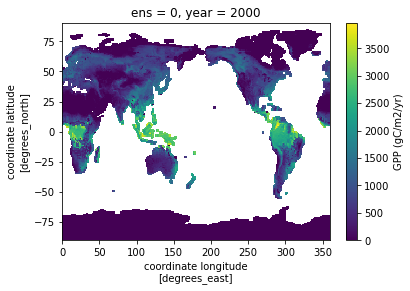

In [29]:
# plot one year from one ensemble member
#   where statement masks the ocean
gpp_ann.sel(ens=0,year=2000).where(ds.landarea>0).plot(cbar_kwargs={'label':'GPP (gC/m2/yr)'});

In [30]:
# sum across gridcells, weighting by landarea
cf1 = 1e6    #km2-->m2
cf2 = 1e-15  #gC-->PgC and kgH2O-->TtH2O
gpp_ann_glob = cf1*cf2*(ds.landarea*gpp_ann).sum(dim=['lat','lon'])

In [31]:
%%time
##  force the calculation:
##     xarray uses lazy evaluation, avoiding crunching the numbers 
##     up to this point, I haven't actually done any calculations!
##     xarray waits until I explicitly require it to do so
##     best to do this ahead of plotting for big calculations
##  Note that if you plan on reusing an intermediate result:
##     e.g. annual averages, 
##     you should probably force the calc and save it at that step
##  If you see files like core-casper25- appearing, you have an issue
gpp_ann_glob = gpp_ann_glob.compute()

CPU times: user 16.7 s, sys: 308 ms, total: 17.1 s
Wall time: 17.3 s


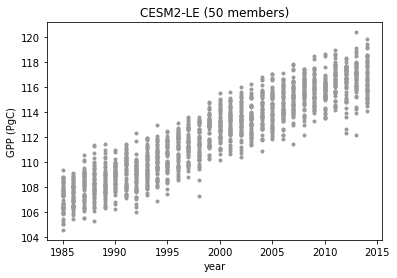

In [32]:
t = np.unique(ds['time.year'])
plt.plot(t,gpp_ann_glob,'.',color=[0.6,0.6,0.6])
plt.xlabel('year')
plt.ylabel('GPP (PgC)')
plt.title('CESM2-LE (50 members)');

### Slows down with lots of data...

In [59]:
%%time
model = 'CESM2'
ens = np.arange(10)     #read only the first 10 ensemble members
fields = ['TBOT']  # always brackets, fields = ['GPP']
firstyear = 1850
lastyear  = 2100

ds = get_monthly(model,ens,fields,firstyear,lastyear)

CPU times: user 5.52 s, sys: 124 ms, total: 5.65 s
Wall time: 6.24 s


In [62]:
%%time
#this function is provided below
tb_ann = aggregate_ann(ds.TBOT,'CESM2')

CPU times: user 19.9 s, sys: 35 s, total: 54.9 s
Wall time: 1min 32s


In [63]:
%%time
#this function is provided below
tb_ann_glob = aggregate_glob(tb_ann,ds.landarea)

CPU times: user 4.85 s, sys: 34.2 s, total: 39 s
Wall time: 51.3 s


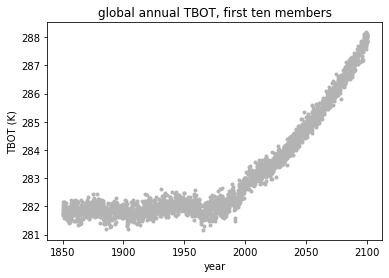

In [66]:
t = tb_ann_glob.year
plt.plot(t,tb_ann_glob,'.',color=[0.7,0.7,0.7])
plt.title('global annual TBOT, first ten members')
plt.ylabel('TBOT (K)')
plt.xlabel('year');

### Extra functions

In [24]:
def get_landarea(model):
    file= get_file(0,model,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

In [40]:
def aggregate_ann(da,model,save=False):
    field = da.name
    cf1 = 24*60*60           # used to convert /s to /d
    cf2 = 1/365              # d->yr
    cf    = {'NEE':cf1,'NBP':cf1,'GPP':cf1,'COL_FIRE_CLOSS':cf1,'TBOT':cf2,'SW':cf2}
    units = {'NEE':'gC/m2','NBP':'gC/m2','GPP':'gC/m2','COL_FIRE_CLOSS':'gC/m2','TBOT':'K','SW':'mmH2O'}
    
    nyears  = len(np.unique(da['time.year']))
    dpm = month_wts(nyears) # days per month
    
    da_ann  = cf[field]*(dpm*da).groupby('time.year').sum(skipna=True).compute() # gridded annual mean or sum
    da_ann.name = field
    da_ann.attrs['units'] = units[field]
    
    if save:
        da_ann.to_netcdf('/glade/work/djk2120/LENSdata/'+model+'_'+field+'_ann.nc')
        
    return da_ann

In [45]:
def aggregate_glob(da,la):
    field = da.name
    cf1 = 1e6    #km2-->m2
    cf2 = 1e-15  #gC-->PgC and kgH2O-->TtH2O
    cfsum  = cf1*cf2
    cfmean = 1/la.sum()
    
    cf    = {'NEE':cfsum,'NBP':cfsum,'GPP':cfsum,'COL_FIRE_CLOSS':cfsum,'TBOT':cfmean,'SW':cfsum}
    units = {'NEE':'PgC','NBP':'PgC','GPP':'PgC','COL_FIRE_CLOSS':'PgC','TBOT':'K','SW':'TtH2O'}
    
    da_glob = cf[field]*(la*da).sum(dim=['lat','lon']).compute()
    da_glob.name = field
    da_glob.attrs['units'] = units[field]
    return da_glob

In [26]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

In [25]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension (h/t rabernat)
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit